In [1]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim

import os
import sys
import time
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable

from scipy.ndimage import rotate
import torchvision.models as models

## Data Cleaning

In [2]:
# PARAMS
batch_size = 256

In [3]:
# TODO: should we apply the below transformations?
transform_train = transforms.Compose([
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_image = transforms.ToPILImage()

In [4]:
print('==> Preparing data..')
trainset = torchvision.datasets.CIFAR10(root='../00_data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=16)

testset = torchvision.datasets.CIFAR10(root='../00_data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4b49031f30>
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, i

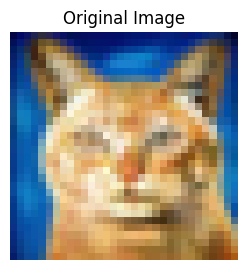

In [5]:
# Choose a specific image from the test set
index = 0  # Change this to select a different image from the test set

# Loop through the testloader to get a batch of images and labels
for images, labels in trainloader:
    # Select a single image and label from the batch
    image = images[index].unsqueeze(0)  # Select a single image and add a batch dimension
    label = labels[index].unsqueeze(0)  # Corresponding label
    break  # Break the loop after the first batch (assuming you want a single image)

# Convert tensors to PIL images for display
to_pil = transforms.ToPILImage()
original_pil = to_pil(image.squeeze(0))

# Display original image, patch, and patched image
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(original_pil)
plt.axis('off')

plt.show()


In [6]:
# Load a pre-trained model (for demonstration purposes)
model = models.resnet50(pretrained=True)
model.eval()

# Choose a target class
target_class = 3  # Change this to your desired target class

/home/codespace/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
import torch
import numpy as np
from PIL import Image

def create_adversarial_patch(model, images, target_classes, epsilon=1, patch_location=(10, 10, 20, 20)):
    patch_x, patch_y, patch_width, patch_height = patch_location

    images = images.clone().detach().requires_grad_(True)
    
    prediction = model(images)
    loss = torch.nn.functional.cross_entropy(prediction, target_classes)

    model.zero_grad()
    loss.backward()

    signed_grad = torch.sign(images.grad.data)

    perturbation = torch.zeros_like(images)
    perturbation[:, :, patch_x:patch_x + patch_width, patch_y:patch_y + patch_height] = epsilon * signed_grad[:, :, patch_x:patch_x + patch_width, patch_y:patch_y + patch_height]

    # Create a blank canvas for the patch with the same size as the patch
    patch = torch.zeros(images.shape[0], images.shape[1], patch_width, patch_height)

    # Apply the perturbation to the blank canvas at the specified patch location
    patch[:, :, :, :] = epsilon * signed_grad[:, :, patch_x:patch_x + patch_width, patch_y:patch_y + patch_height]

    # Convert tensor to NumPy array and reshape
    patch_np = patch[0].cpu().detach().numpy().transpose(1, 2, 0)
    patch_np = ((patch_np + 1) * 0.5 * 255).astype(np.uint8)  # Convert from [-1, 1] to [0, 255] range

    # Create PIL image from NumPy array with patch size
    patch_image = Image.fromarray(patch_np)

    return patch_image


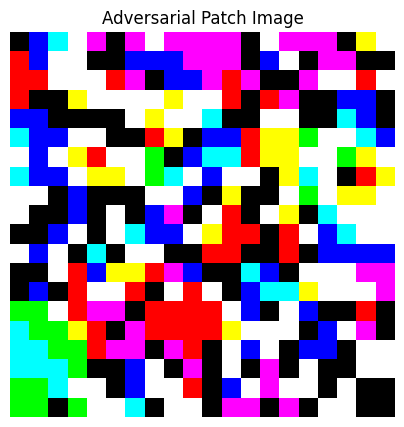

In [8]:
# Convert PIL image to a PyTorch tensor
def pil_to_tensor(image):
    preprocess = transforms.Compose([transforms.ToTensor()])
    return preprocess(image).unsqueeze(0)  # Adding a batch dimension

# Assuming 'original_pil' is your PIL Image and 'model' is your neural network model
original_pil = transform_image(trainset[1][0])  # Transform the image if necessary
input_tensor = pil_to_tensor(original_pil)

# Assuming 'label' is the target label for the adversarial patch
result_image = create_adversarial_patch(model, input_tensor, label)
# Convert the PIL image to NumPy array for plotting
result_np = np.array(result_image)

# Display the adversarial patch image in a plot with a larger size
plt.figure(figsize=(5, 5))  # Adjust the figure size as needed
plt.imshow(result_np)
plt.axis('off')  # Remove axes
plt.title('Adversarial Patch Image')
plt.show()

In [19]:
def patch_application_operator(img_index, model, input_tensor, label, h='center', v='center', ratio=3, rotation=0):
    """A Patch Application Operator function to apply a patch along with its transformations
      to a CIFAR-10 image given an index in the training / test set.

    Args:
        img_index (int): the index of the image in the training / test set
        model: Your neural network model
        input_tensor: The input tensor representing the original image
        label: The target label for the adversarial patch
        h (str): the horizontal position of the patch (default: 'center') - see mode_to_value keys for possible values
        v (str): the vertical position of the patch (default: 'center') - see mode_to_value keys for possible values
        ratio (int): the ratio of the patch size to the image size (default: 3). Essentially controls the scale of the image.
        rotation (int): the angle of rotation of the patch (default: 0)

    Returns:
        img (PIL): the image with the patch applied
    """

    # Load and transform the original image
    image = transform_image(trainset[img_index][0])

    # Generate the adversarial patch
    result_image = create_adversarial_patch(model, input_tensor, label)
    
    # Resize and rotate the patch
    patch_image = result_image.resize((image.width // ratio, image.height // ratio), Image.LANCZOS)
    patch_image = patch_image.rotate(rotation)

    # Ensure both images have an alpha channel
    image = image.convert("RGBA")
    patch_image = patch_image.convert("RGBA")

    # map from mode value to a function that returns the correct value position
    mode_to_value = {
        'left': lambda width, path: 0,
        'center_h': lambda width, path: width // 2 - path.width // 2,
        'center_v': lambda height, path: height // 2 - path.height // 2,
        'right': lambda width, path: width - path.width,
        'up': lambda height, path: 0,
        'down': lambda height, path: height - path.height,
    }

    plt.figure(figsize=(2.5, 2.5))
    plt.title("Original")
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    x = mode_to_value[h if h != 'center' else 'center_h'](image.width, patch_image)
    y = mode_to_value[v if v != 'center' else 'center_v'](image.height, patch_image)

    print(f"Patch will be placed {h}-{v}")

    image.paste(patch_image, (x, y), mask=patch_image)

    plt.figure(figsize=(2.5, 2.5))
    plt.title("Patched")
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Convert image to tensor
    # image = transform_test(image)

    # # Display the final result
    # plt.figure(figsize=(2.5, 2.5))
    # plt.title("Result")
    # plt.imshow(image)
    # plt.axis('off')
    # plt.show()

    # # Display the final result
    # image = np.transpose(image.squeeze().cpu().detach().numpy(), (1, 2, 0))
    
    # plt.figure(figsize=(2.5, 2.5))
    # plt.title("Result")
    # plt.imshow(image)
    # plt.axis('off')
    # plt.show()

    # return image

    # Display the final result
    # image = np.array(image)  # Convert PIL Image to NumPy array
    # image = np.array(image)[:, :, :3]  # Extract RGB channels if the image has an alpha channel

    # plt.figure(figsize=(2.5, 2.5))
    # plt.title("Result")
    # plt.imshow(image)
    # plt.axis('off')
    # plt.show()

    return image




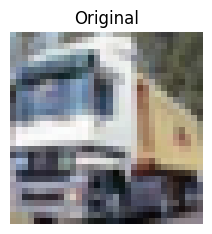

Patch will be placed left-up


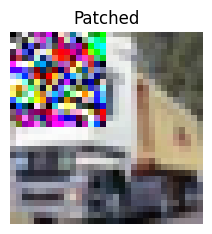

In [20]:
# Run the patch_application_operator function with desired parameters
result_image = patch_application_operator(
    img_index=1,
    model=model,
    input_tensor=input_tensor,
    label=label,
    h='left',
    v='up',
    ratio=2,
    rotation=180
)

## Other

In [16]:
# Define FGSM function to generate adversarial patches applied to a specific location for a batch
def create_adversarial_patch(model, images, target_classes, epsilon=0.01, patch_location=(10, 10, 20, 20)):
    patch_x, patch_y, patch_width, patch_height = patch_location

    images = images.clone().detach().requires_grad_(True)

    prediction = model(images)
    loss = torch.nn.functional.cross_entropy(prediction, target_classes)

    model.zero_grad()
    loss.backward()

    signed_grad = torch.sign(images.grad.data)

    perturbation = torch.zeros_like(images)
    perturbation[:, :, patch_x:patch_x + patch_width, patch_y:patch_y + patch_height] = epsilon * signed_grad[:, :, patch_x:patch_x + patch_width, patch_y:patch_y + patch_height]

    return perturbation

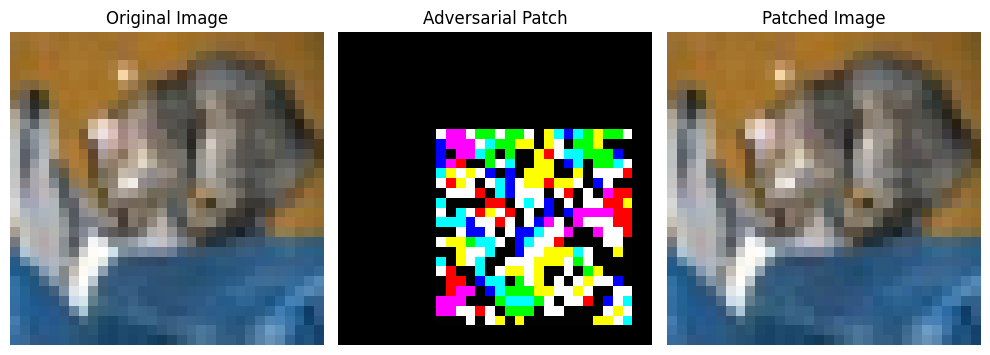

In [18]:
# Choose a specific image from the test set
index = 0  # Change this to select a different image from the test set
patch_location = (10, 10, 20, 20)  # Define the patch location

# Loop through the testloader to get a batch of images and labels
for images, labels in testloader:
    # Select a single image and label from the batch
    image = images[index].unsqueeze(0)  # Select a single image and add a batch dimension
    label = labels[index].unsqueeze(0)  # Corresponding label
    break  # Break the loop after the first batch (assuming you want a single image)

# Generate adversarial patch
epsilon = 0.01  # Adjust epsilon as needed
perturbation = create_adversarial_patch(model, image, label, epsilon, patch_location)

# Apply the patch to the image
patched_image = image + perturbation
patched_image = torch.clamp(patched_image, 0, 1)  # Ensure pixel values are within [0, 1] range

# Convert tensors to PIL images for display
to_pil = transforms.ToPILImage()
original_pil = to_pil(image.squeeze(0))
patch_pil = to_pil(perturbation.squeeze(0))
patched_pil = to_pil(patched_image.squeeze(0))

# Display original image, patch, and patched image
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(original_pil)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Adversarial Patch')
plt.imshow(patch_pil)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Patched Image')
plt.imshow(patched_pil)
plt.axis('off')

plt.tight_layout()
plt.show()


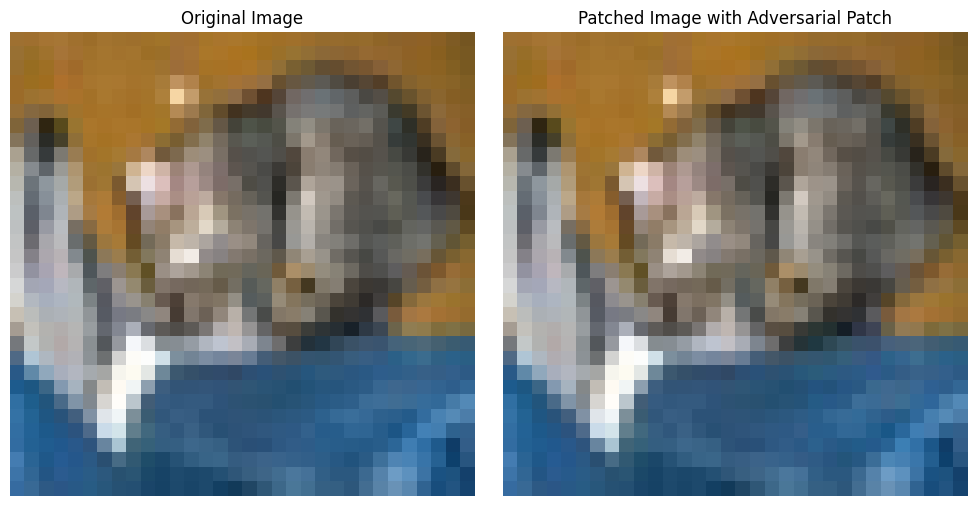

In [19]:
import torch
import torchvision
from torchvision import transforms
from torchvision import models
import matplotlib.pyplot as plt

# Assume 'model', 'transform_test', 'testloader', and 'create_adversarial_patch' are already defined as in your code.

# Choose a specific image from the test set
index = 0  # Change this to select a different image from the test set
patch_location = (10, 10, 20, 20)  # Define the patch location

# Loop through the testloader to get a batch of images and labels
for images, labels in testloader:
    # Select a single image and label from the batch
    image = images[index].unsqueeze(0).clone()  # Select a single image and add a batch dimension
    label = labels[index].unsqueeze(0)  # Corresponding label
    break  # Break the loop after the first batch (assuming you want a single image)

# Generate adversarial patch
epsilon = 0.01  # Adjust epsilon as needed
perturbation = create_adversarial_patch(model, image, label, epsilon, patch_location)

# Ensure the perturbation size matches the patch location's dimensions
patch_x, patch_y, patch_width, patch_height = patch_location
perturbation = perturbation[:, :, :patch_width, :patch_height]

# Apply the patch to the image at the specified location
with torch.no_grad():
    image[:, :, patch_x:patch_x + patch_width, patch_y:patch_y + patch_height] += perturbation

# Ensure pixel values are within [0, 1] range
image = torch.clamp(image, 0, 1)

# Convert tensors to PIL images for display
to_pil = transforms.ToPILImage()
original_pil = to_pil(image.squeeze(0))  # Original image with the patch applied

# Display the original image and the patched image side by side
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(to_pil(images[index]))
plt.axis('off')

# Patched image with the adversarial patch
plt.subplot(1, 2, 2)
plt.title('Patched Image with Adversarial Patch')
plt.imshow(original_pil)
plt.axis('off')

plt.tight_layout()
plt.show()


In [20]:
# Assuming 'image' contains the patched image tensor, 'original_image' contains the original image tensor,
# and 'patch_location' contains the patch coordinates

# Get the original image tensor (before patching)
original_image = images[index].unsqueeze(0)  # Assuming 'images' contains the original images

# Extract the specific patch area from both the original and patched images
patch_x, patch_y, patch_width, patch_height = patch_location

original_patch_area = original_image[:, :, patch_x:patch_x + patch_width, patch_y:patch_y + patch_height]
patched_patch_area = image[:, :, patch_x:patch_x + patch_width, patch_y:patch_y + patch_height]

# Convert the patch area tensors to NumPy arrays for easy inspection
original_patch_np = original_patch_area.squeeze(0).permute(1, 2, 0).cpu().numpy()
patched_patch_np = patched_patch_area.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Print the pixel values of the original and patched patch areas
print("Original Patch Area Pixel Values:")
print(original_patch_np)

print("\nPatched Patch Area Pixel Values:")
print(patched_patch_np)


Original Patch Area Pixel Values:
[[[0.8627451  0.7490196  0.7372549 ]
  [0.6431373  0.5294118  0.5137255 ]
  [0.7176471  0.62352943 0.60784316]
  ...
  [0.30588236 0.30980393 0.28627452]
  [0.23137255 0.23137255 0.23137255]
  [0.16078432 0.14117648 0.12941177]]

 [[0.78039217 0.67058825 0.6431373 ]
  [0.6666667  0.5568628  0.52156866]
  [0.7254902  0.6313726  0.5921569 ]
  ...
  [0.33333334 0.34117648 0.31764707]
  [0.28627452 0.29411766 0.30588236]
  [0.21568628 0.20784314 0.21568628]]

 [[0.65882355 0.5647059  0.49411765]
  [0.5372549  0.44705883 0.36862746]
  [0.7294118  0.6509804  0.5803922 ]
  ...
  [0.3372549  0.34117648 0.31764707]
  [0.32941177 0.34117648 0.34901962]
  [0.28627452 0.28627452 0.28627452]]

 ...

 [[0.21176471 0.36862746 0.5058824 ]
  [0.1882353  0.34117648 0.4862745 ]
  [0.22745098 0.38039216 0.52156866]
  ...
  [0.15686275 0.39607844 0.6       ]
  [0.2627451  0.5058824  0.7137255 ]
  [0.2627451  0.49411765 0.6901961 ]]

 [[0.20392157 0.36862746 0.5019608 ]
  [

In [20]:
# Assuming 'image' contains the patched image tensor and 'original_image' contains the original image tensor

# Get the original image tensor (before patching)
original_image = images[index].unsqueeze(0)  # Assuming 'images' contains the original images

# Convert the original and patched image tensors to NumPy arrays for easy inspection
original_image_np = original_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
patched_image_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Print the pixel values of the original and patched images
print("Original Image Pixel Values:")
print(original_image_np)

print("\nPatched Image Pixel Values:")
print(patched_image_np)


Original Image Pixel Values:
[[[0.61960787 0.4392157  0.19215687]
  [0.62352943 0.43529412 0.18431373]
  [0.64705884 0.45490196 0.2       ]
  ...
  [0.5372549  0.37254903 0.14117648]
  [0.49411765 0.35686275 0.14117648]
  [0.45490196 0.33333334 0.12941177]]

 [[0.59607846 0.4392157  0.2       ]
  [0.5921569  0.43137255 0.15686275]
  [0.62352943 0.44705883 0.1764706 ]
  ...
  [0.53333336 0.37254903 0.12156863]
  [0.49019608 0.35686275 0.1254902 ]
  [0.46666667 0.34509805 0.13333334]]

 [[0.5921569  0.43137255 0.18431373]
  [0.5921569  0.42745098 0.12941177]
  [0.61960787 0.43529412 0.14117648]
  ...
  [0.54509807 0.38431373 0.13333334]
  [0.50980395 0.37254903 0.13333334]
  [0.47058824 0.34901962 0.12941177]]

 ...

 [[0.26666668 0.4862745  0.69411767]
  [0.16470589 0.39215687 0.5803922 ]
  [0.12156863 0.34509805 0.5372549 ]
  ...
  [0.14901961 0.38039216 0.57254905]
  [0.05098039 0.2509804  0.42352942]
  [0.15686275 0.33333334 0.49803922]]

 [[0.23921569 0.45490196 0.65882355]
  [0.192

In [7]:
dummy_images = torch.randn(batch_size, 3, 224, 224)  # Replace this with your batch of images
dummy_labels = torch.randint(0, 10, (batch_size,))  # Replace this with corresponding labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


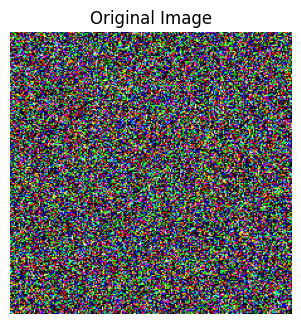

In [8]:
import random

# Display a randomly selected image and its adversarial version
plt.figure(figsize=(8, 4))

# Choose a random index within the batch
random_index = random.randint(0, batch_size - 1)

# Original image
original_img = np.transpose(dummy_images[random_index].numpy(), (1, 2, 0))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_img)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

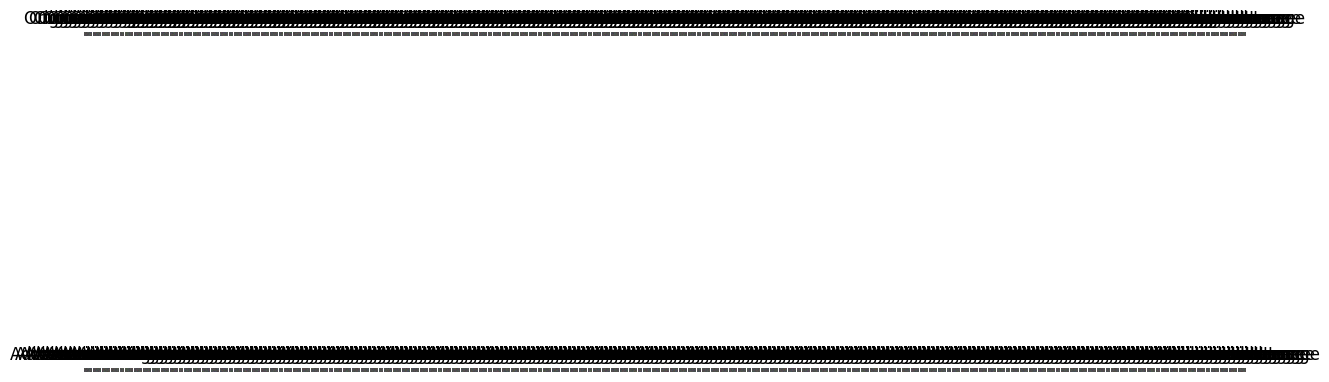

In [8]:
# Generate adversarial patches applied to a specific location for the batch
patch_location = (10, 10, 20, 20)  # (x, y, width, height) - Modify this to specify the location
adversarial_patches = create_adversarial_patch(model, dummy_images, dummy_labels, patch_location=patch_location)

# Apply the patches to the images
adversarial_images = dummy_images + adversarial_patches
adversarial_images = torch.clamp(adversarial_images, -1, 1)

# Convert tensors to NumPy arrays for visualization
adversarial_images_np = adversarial_images.permute(0, 2, 3, 1).detach().cpu().numpy()
adversarial_patches_np = adversarial_patches.permute(0, 2, 3, 1).detach().cpu().numpy()

# Display the original and adversarial images along with the patches for each image in the batch
num_images = batch_size
plt.figure(figsize=(15, 8))

for i in range(num_images):
    plt.subplot(2, num_images, i + 1)
    plt.title('Original Image')
    plt.imshow(np.transpose(dummy_images[i].numpy(), (1, 2, 0)))
    plt.axis('off')

    plt.subplot(2, num_images, i + num_images + 1)
    plt.title('Adversarial Image')
    plt.imshow(adversarial_images_np[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


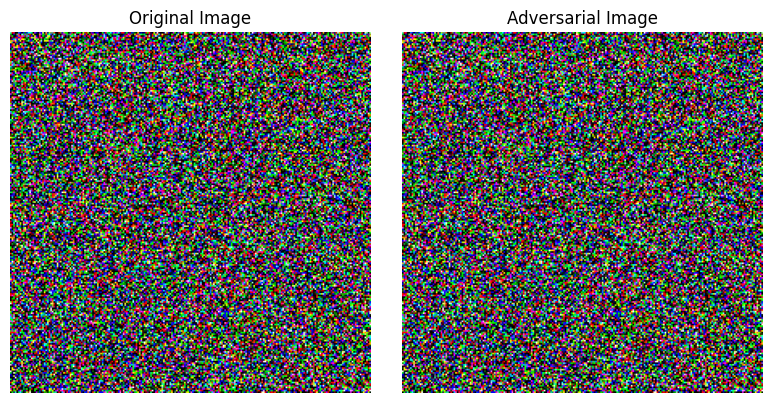

In [10]:
import random

# Display a randomly selected image and its adversarial version
plt.figure(figsize=(8, 4))

# Choose a random index within the batch
random_index = random.randint(0, batch_size - 1)

# Original image
original_img = np.transpose(dummy_images[random_index].numpy(), (1, 2, 0))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_img)
plt.axis('off')

# Adversarial image
adversarial_img = adversarial_images_np[random_index]
plt.subplot(1, 2, 2)
plt.title('Adversarial Image')
plt.imshow(adversarial_img)
plt.axis('off')

plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


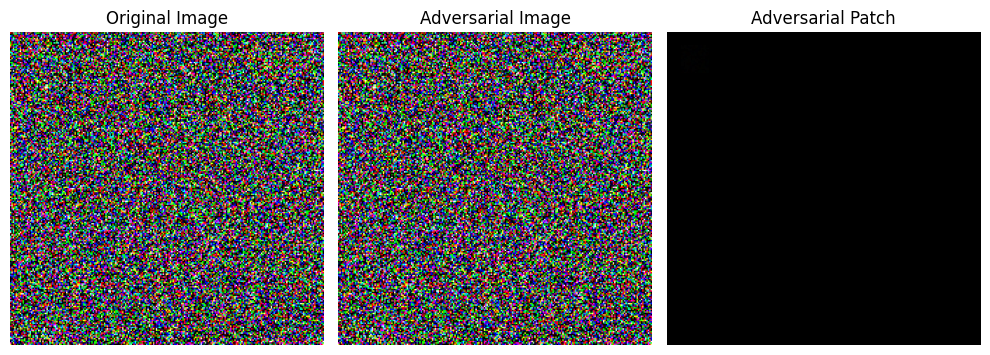

In [9]:
import random

# Display a randomly selected image from the batch along with its patch
plt.figure(figsize=(10, 5))

# Choose a random index within the batch
random_index = random.randint(0, batch_size - 1)

# Original image
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(np.transpose(dummy_images[random_index].numpy(), (1, 2, 0)))
plt.axis('off')

# Adversarial image
plt.subplot(1, 3, 2)
plt.title('Adversarial Image')
plt.imshow(adversarial_images_np[random_index])
plt.axis('off')

# Adversarial patch
plt.subplot(1, 3, 3)
plt.title('Adversarial Patch')
adversarial_patch_np = adversarial_patches[random_index].permute(1, 2, 0).detach().cpu().numpy()
plt.imshow(adversarial_patch_np)
plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
# Generate adversarial patches applied to a specific location for the batch
patch_location = (10, 10, 20, 20)  # (x, y, width, height) - Modify this to specify the location
adversarial_patches = create_adversarial_patch(model, dummy_images, dummy_labels, patch_location=patch_location)

# Apply the patches to the images
adversarial_images = dummy_images + adversarial_patches
adversarial_images = torch.clamp(adversarial_images, -1, 1)

# Convert tensors to NumPy arrays for visualization
adversarial_images_np = adversarial_images.permute(0, 2, 3, 1).detach().cpu().numpy()
adversarial_patches_np = adversarial_patches.permute(0, 2, 3, 1).detach().cpu().numpy()

# Display the original and adversarial images along with the patches for each image in the batch
num_images = batch_size
plt.figure(figsize=(15, 8))

for i in range(num_images):
    plt.subplot(2, num_images, i + 1)
    plt.title('Original Image')
    plt.imshow(np.transpose(dummy_images[i].numpy(), (1, 2, 0)))
    plt.axis('off')

    plt.subplot(2, num_images, i + num_images + 1)
    plt.title('Adversarial Image')
    plt.imshow(adversarial_images_np[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

TypeError: only integer tensors of a single element can be converted to an index

In [10]:
# Choose an image from the dataset
image, _ = next(iter(trainloader))

# Generate adversarial patch applied to a specific location
patch_location = (10, 10, 20, 20)  # (x, y, width, height) - Modify this to specify the location
adversarial_patch = create_adversarial_patch(model, image, target_class, patch_location=patch_location)

# Apply the patch to the image
adversarial_image = image + adversarial_patch
adversarial_image = torch.clamp(adversarial_image, -1, 1)

# Test the patched image on the model
prediction_original = model(image)
prediction_adversarial = model(adversarial_image)

print("Original Prediction:", torch.topk(prediction_original, 1)[1])
print("Adversarial Prediction:", torch.topk(prediction_adversarial, 1)[1])

ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcaf6c10ca0>
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/codespace/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/codespace/.python/current/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/codespace/.python/current/lib/python3.10/multiprocessing/popen_fork.py",

ValueError: Expected input batch_size (256) to match target batch_size (1).

In [ ]:


# Load and preprocess a single image from the CIFAR-10 dataset
image_path = 'path_to_your_image.jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_image = preprocess(image).unsqueeze(0)  # Add batch dimension

# Define FGSM function to generate adversarial patch applied to a specific location
def create_adversarial_patch(model, image, target_class, epsilon=0.01, patch_location=(10, 10, 20, 20)):
    patch_x, patch_y, patch_width, patch_height = patch_location

    image = image.clone().detach().requires_grad_(True)

    prediction = model(image)
    loss = torch.nn.functional.cross_entropy(prediction, torch.tensor([target_class]))

    model.zero_grad()
    loss.backward()

    signed_grad = torch.sign(image.grad.data)

    perturbation = torch.zeros_like(image)
    perturbation[:, :, patch_x:patch_x + patch_width, patch_y:patch_y + patch_height] = epsilon * signed_grad[:, :, patch_x:patch_x + patch_width, patch_y:patch_y + patch_height]

    return perturbation

# Generate adversarial patch applied to a specific location
patch_location = (10, 10, 20, 20)  # (x, y, width, height) - Modify this to specify the location
adversarial_patch = create_adversarial_patch(model, input_image, target_class, patch_location=patch_location)

# Apply the patch to the image
adversarial_image = input_image + adversarial_patch
adversarial_image = torch.clamp(adversarial_image, -1, 1)

# Convert tensor to NumPy array for visualization
adversarial_image_np = adversarial_image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

# Display the original and adversarial images along with the patch
plt.figure(figsize=(10, 5))

# Display the original image
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')

# Display the adversarial image
plt.subplot(1, 3, 2)
plt.title('Adversarial Image')
plt.imshow(adversarial_image_np)
plt.axis('off')

# Display the adversarial patch
plt.subplot(1, 3, 3)
plt.title('Adversarial Patch')
adversarial_patch_np = adversarial_patch.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
plt.imshow(adversarial_patch_np)
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Define FGSM function to generate adversarial patch applied to a specific location
def create_adversarial_patch(model, image, target_class, epsilon=0.01, patch_location=(10, 10, 20, 20)):
    patch_x, patch_y, patch_width, patch_height = patch_location

    image = image.clone().detach().requires_grad_(True)

    prediction = model(image)
    loss = torch.nn.functional.cross_entropy(prediction, torch.tensor([target_class]))

    model.zero_grad()
    loss.backward()

    signed_grad = torch.sign(image.grad.data)

    perturbation = torch.zeros_like(image)
    perturbation[:, :, patch_x:patch_x + patch_width, patch_y:patch_y + patch_height] = epsilon * signed_grad[:, :, patch_x:patch_x + patch_width, patch_y:patch_y + patch_height]

    return perturbation